# DESI PV Y1 $z$-bin TFR Calibration

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  Only use galaxies that pass Alex's criteria cuts:
* $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)
* $70 < V(0.4R_{26}) < 300$ km/s
* $V(0.4R_{26}) <$ minimum of (300 km/s, $10^{0.3(\mu_{CMB} - 34 + 5\log h) + 2}$)

Version: **10 August 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

/Users/kdouglass/miniforge3/envs/desi/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.365240555641251e-05,122.3223893029039,9.671537005812278,N
55,SGA-2020 55,PGC1203947

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

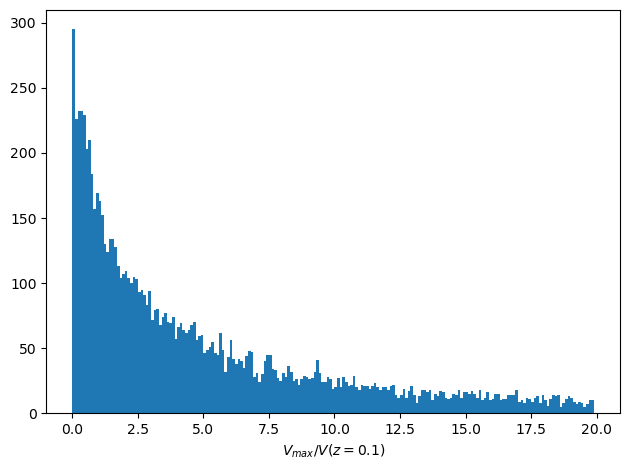

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [8]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

## Define dwarfs

We defined dwarfs to have $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)

In [9]:
# Using Alex's notation for consistency
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

Rlim_eff = np.minimum(Rlim, sgatab['MU_ZCMB'] + Mlim)
dwarf_boolean = sgatab['R_MAG_SB26'] > Rlim_eff

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [10]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [11]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [12]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [13]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [14]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [15]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MU_ZCMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,mag,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.036493

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not a dwarf galaxy
* $70~\mathrm{km/s} < V_\mathrm{rot} < 300~\mathrm{km/s}$ at $0.4R_{26}$
* $\log(V_\mathrm{rot}) <$ minimum of log(300 km/s) or $0.3(\mu(z_{CMB}) - 34 - 5\log h) + 2$

The first 1.5 items have already been applied (our VI results have already been applied, but not John's).

In [16]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

# Alex's velocity cut
Vmin = 70 # km/s
Vmax = 300 # km/s
is_good_vel = (sgatab['V_0p4R26'] > Vmin) & (sgatab['V_0p4R26'] < Vmax)

#- Alex's sliding velocity maximum
logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)
is_good_vel2 = sgatab['V_0p4R26'] < np.minimum(Vmax, 10**(logVM_slope*(sgatab['MU_ZCMB'] - logVM_zero) + 2))

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~dwarf_boolean & is_good_vel & is_good_vel2

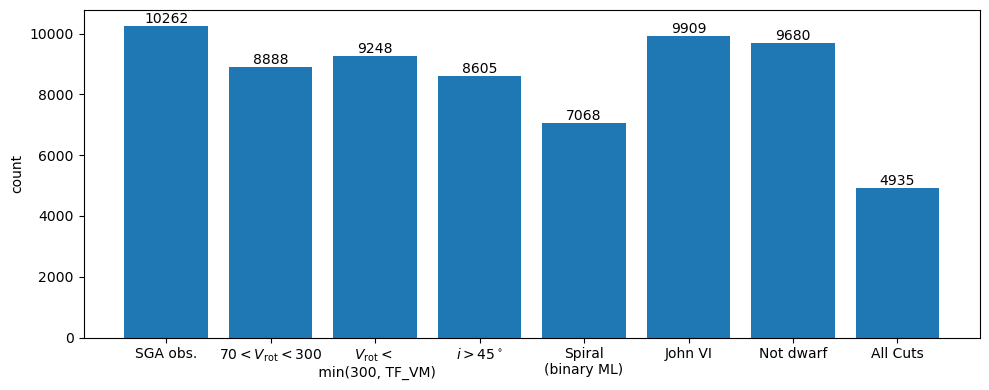

In [17]:
data = {
    'SGA obs.' : len(sgatab),
    r'$70 < V_\mathrm{rot} < 300$' : np.sum(is_good_vel),
    '$V_\mathrm{rot} <$ \n min(300, TF_VM)' : np.sum(is_good_vel2), 
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    'Not dwarf' : np.sum(~dwarf_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(10,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [18]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [19]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [20]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [21]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [22]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [23]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [24]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [25]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [26]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [27]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [28]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [29]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

## Load SN Ia Calibrators for the TFR Zero Point

Updated (July 2025) list of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [30]:
# zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/combinedpv'
zeroptpath = '.'

In [31]:
zeroptab_all = Table.read(os.path.join(zeroptpath, 'PVsample_group_lookup+SNe.csv'))

# This is a list of all the TF + FP galaxies; only keep those with non-zero `MU_SN`
zeroptab_secondary = zeroptab_all[zeroptab_all['MU_SN'] > 0]
zeroptab_secondary[:5]

ID,group,zcmb,MU,MU_ERR,LOGDIST,LOGDIST_ERR,FP_FLAG,MU_FP,MU_FP_ERR,MU_TF,MU_TF_ERR,LOGDIST_FP,LOGDIST_FP_ERR,LOGDIST_TF,LOGDIST_TF_ERR,zcmb_gr,MU_SN,MU_SN_ERR,MU_DESI,MU_DESI_ERR,LOGDIST_SN,LOGDIST_SN_ERR,LOGDIST_DESI,LOGDIST_DESI_ERR
int64,str11,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633328785066757,2MRS711+,0.0039676663986918,32.00097867224519,0.6604661904704527,-0.3237695642772998,0.13209323809409051,True,31.73849041214853,0.48077000045780094,0.0,0.0,-0.24903482597904422,0.0961540000915601,0.0,0.0,0.0039533333333333,31.666571207539782,0.09129591053344505,31.738468671967322,0.48044940574448897,-0.28848911070838973,0.01825918210668901,-0.24902863619077392,0.09608988114889777
39633335592422861,2MRS711+,0.0044219686972581,31.443432913341425,0.7001885307384135,-0.16502708807805433,0.14003770614768266,True,31.73849041214853,0.48077000045780094,0.0,0.0,-0.24903482597904422,0.0961540000915601,0.0,0.0,0.0039533333333333,31.666571207539782,0.09129591053344505,31.738468671967322,0.48044940574448897,-0.28848911070838973,0.01825918210668901,-0.24902863619077392,0.09608988114889777
530182,2MRS99+,0.0047930320652416,32.47940875769096,0.7239065513601364,-0.3371487771800957,0.1447813102720272,False,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681
2842557700636673,2MRS99+,0.0061633210470812,30.47296800289217,0.7404426954770842,0.17379783886345607,0.14808853909541678,True,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681
2842569767649280,2MRS99+,0.0072261998346456,30.84064192659754,0.6981248856923716,0.1697020751725316,0.13962497713847433,True,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681


In [32]:
# zeroptab_primary = Table.read(os.path.join(zeroptpath, 'new_Pplus_group_match+SGA.csv'))
zeroptab_primary = Table.read(os.path.join(zeroptpath, 'new_Pplus_group_match+SGA_avg.csv'))
zeroptab_primary[:5]

CID,zCMB,zCMBERR,zHEL,zHELERR,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,USED_IN_SH0ES_HF,RA_SN,DEC_SN,ID_gr,ID_gal,ra_Lim,dec_Lim,source,sep_SN-Lim,SGA_ID,sep_Lim-SGA
str15,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str9,str19,float64,float64,str9,float64,float64,float64
SN2016esh,0.04488,3e-05,0.04457,3e-05,36.1579,0.12988610395265537,-9.0,0,0,241.06,16.6902,SDSS228,SDSS581524,241.05988,16.69016,SDSS228+,0.4311776000325898,--,--
ASASSN-16fo,0.02994,0.00021,0.0289,0.00021,35.4803,0.12944141531982722,-9.0,0,0,203.149,-5.2725,2dF15428,2dF128339,203.14912,-5.27278,2dF15428,1.0929274169111631,64475.0,0.4609341882013722
ASASSN-16ct,0.04252,4e-05,0.04191,4e-05,36.2457,0.14873066260862283,-9.0,0,0,228.476,4.7573,SDSS1466,SDSS102315,228.47627,4.75715,SDSS1466,1.115336665428975,--,--
ASASSN-15so,0.00773,1e-05,0.00702,1e-05,32.7527,0.1274923134937946,32.8026,1,0,168.546,48.3187,2MRS4707,2MRS662,168.54575,48.31838,2MRS4707+,1.3004787534374072,995356.0,0.9298391203772391
ASASSN-15la,0.02845,1e-05,0.02782,1e-05,35.0558,0.15650734807030628,-9.0,0,1,213.213,35.7112,SDSS962,SDSS302584,213.21349,35.71089,2MRS834+,1.8232536690592336,737288.0,0.200539881958872


In [33]:
# Remove non-SGA galaxies
zeroptab_primary_SGA = zeroptab_primary[~zeroptab_primary['SGA_ID'].mask]

In [34]:
# Join the two 0pt catalogs together
zeroptab = join(zeroptab_secondary['ID', 'MU_SN', 'MU_SN_ERR', 'group'], 
                zeroptab_primary_SGA['SGA_ID', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG', 'CID'], 
                keys_left='ID', keys_right='SGA_ID', 
                join_type='outer')
zeroptab[:5]

ID,MU_SN,MU_SN_ERR,group,SGA_ID,MU_SH0ES,MU_SH0ES_ERR_DIAG,CID
int64,float64,float64,str11,float64,float64,float64,str15
--,--,--,--,10461.0,35.9905,0.2810696710781866,2007hu
--,--,--,--,20779.0,35.8698,0.13604785922608265,ASASSN-16db
--,--,--,--,22915.0,35.0136,0.17318562295987505,SNF20080514-002
--,--,--,--,37527.0,36.3303,0.09554459691683251,1995ac
40926,37.032,0.1278163917500412,2dF416+,--,--,--,--


In [35]:
# Merge together the ID and SGA_ID columns
zeroptab['SGA_ID'][zeroptab['SGA_ID'].mask] = zeroptab['ID'][zeroptab['SGA_ID'].mask]

# Remmove "old" ID column
zeroptab.remove_column('ID')

zeroptab[:5]

MU_SN,MU_SN_ERR,group,SGA_ID,MU_SH0ES,MU_SH0ES_ERR_DIAG,CID
float64,float64,str11,float64,float64,float64,str15
--,--,--,10461.0,35.9905,0.2810696710781866,2007hu
--,--,--,20779.0,35.8698,0.13604785922608265,ASASSN-16db
--,--,--,22915.0,35.0136,0.17318562295987505,SNF20080514-002
--,--,--,37527.0,36.3303,0.09554459691683251,1995ac
37.032,0.1278163917500412,2dF416+,40926.0,--,--,--


In [36]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
idx = np.isin(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])

#  Merge the tables so we can use the zero point later.
zeroptab = join(sgatab, zeroptab[idx], keys='SGA_ID')

#- Write catalog to file
# zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab['SGA_ID', 'GALAXY', 'MU_SN', 'MU_SH0ES', 'group', 'CID'].show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,SGA_ID,GALAXY,MU_SN,MU_SH0ES,group,CID
0,40926.0,PGC1068066,37.032,--,2dF416+,--
1,109750.0,PGC007299,36.481301221344594,36.481301221344594,2005hc+,2005hc+
2,124900.0,PGC1111212,36.8581,--,2dF2679+,--
3,185629.0,PGC1313612,35.825,--,SDSS32+,--
4,236390.0,PGC1093912,37.0786,--,2dF14+,--
5,364828.0,PGC1259192,35.6231,--,2MRS294+,--
6,506101.0,PGC1082809,37.0786,--,2dF14+,--
7,656304.0,PGC032277,36.1263,36.1263,2dF45+,PS16axi
8,726137.0,PGC1115995,35.0276,--,6dF501+,--
9,927499.0,2MASXJ15154537+0647157,35.825,--,SDSS32+,--


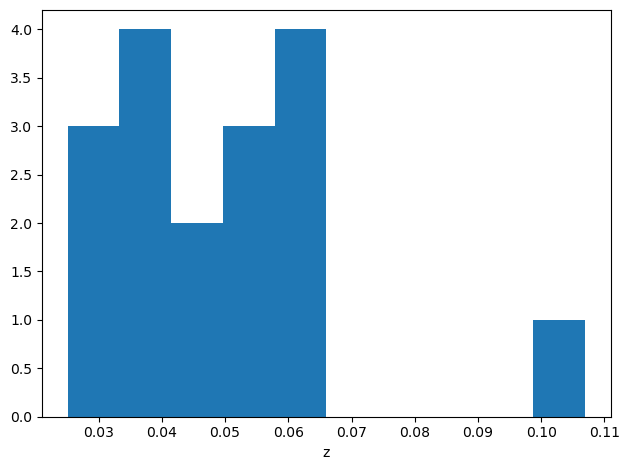

In [37]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])#, bins=np.arange(0, 0.12, 0.0025))

plt.xlabel('z');

In [38]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [39]:
np.unique(zeroptab['CID'], return_counts=True)

(<MaskedColumn name='CID' dtype='str15' length=5>
 2005hc+
  500038
      --
 PS15cms
 PS16axi,
 array([ 1,  1, 13,  1,  1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

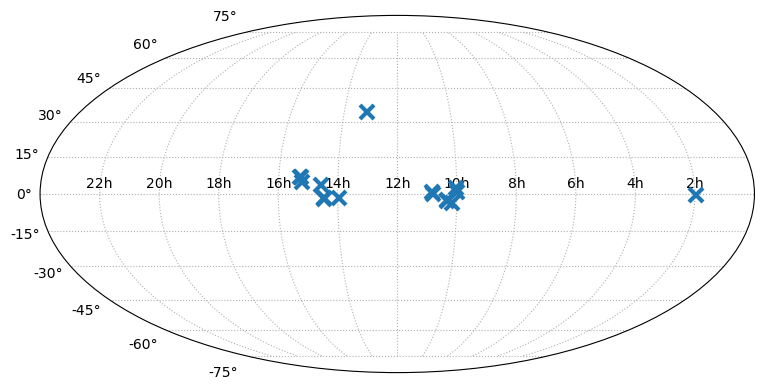

In [40]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

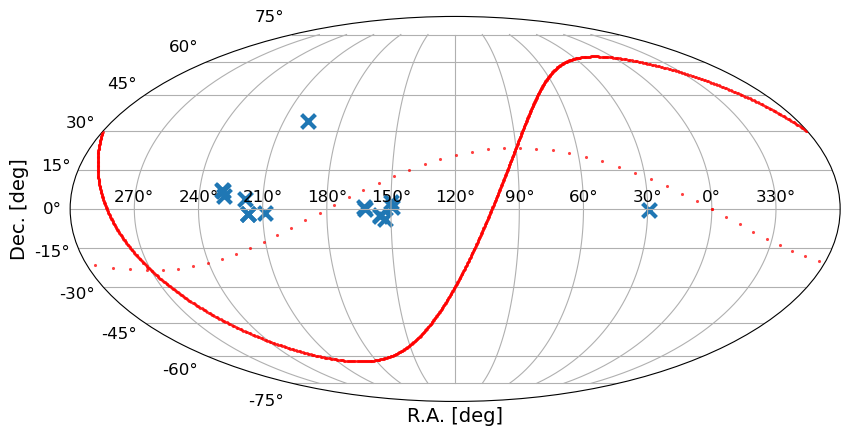

In [41]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3,
           color='tab:blue')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_0pt_sky_Anthony2.png', 
#             dpi=150, 
#             facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [42]:
#- Clean up the distance modulus
use_primary = ~zeroptab['MU_SH0ES'].mask
mu = zeroptab['MU_SN']
mu[use_primary] = zeroptab['MU_SH0ES'][use_primary]
# mu = zeroptab['MU_PRIMARY']

mu_err = zeroptab['MU_SN_ERR']
mu_err[use_primary] = zeroptab['MU_SH0ES_ERR_DIAG'][use_primary]

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_ERR'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + mu_err**2)

In [41]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt-Anthony2_calib_z0p1_R26dwarfs.fits', 
               overwrite=True)

In [43]:
zeroptab['SGA_ID', 'D26_kpc', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'V_0p4R26', 'V_0p4R26_ERR'].show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,SGA_ID,D26_kpc,R_MAG_SB26,R_MAG_SB26_ERR,V_0p4R26,V_0p4R26_ERR
,,kpc,,,,
0,40926.0,28.58454771708347,16.696472,0.0065811076,136.35142178525604,11.074703336870135
1,109750.0,42.34779922242629,15.013978,0.0113418605,221.3755771256751,8.774282536170919
2,124900.0,26.760046348583327,16.818043,0.032047212,143.17112816644325,34.61067012636111
3,185629.0,15.943648701231227,16.74443,0.023938801,118.22404252663176,10.30302451309546
4,236390.0,29.201396206101446,17.108109,0.030829139,132.93922299389146,9.693889582725964
5,364828.0,15.101189979483186,17.001926,0.019800633,98.2998665738336,10.911703633791037
6,506101.0,32.09442197347618,16.420128,0.02698361,148.86839576404628,7.266022158130458
7,656304.0,23.69295520949068,15.03111,0.0047636353,181.73653288642595,10.048159182113666
8,726137.0,14.839423182103562,16.622995,0.030130567,84.96624512331216,9.15214548743703


# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [44]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax + dz, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [45]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  292 galaxies
 1  0.030 < z <= 0.035  338 galaxies
 2  0.035 < z <= 0.040  309 galaxies
 3  0.040 < z <= 0.045  323 galaxies
 4  0.045 < z <= 0.050  350 galaxies
 5  0.050 < z <= 0.055  356 galaxies
 6  0.055 < z <= 0.060  312 galaxies
 7  0.060 < z <= 0.065  328 galaxies
 8  0.065 < z <= 0.070  317 galaxies
 9  0.070 < z <= 0.075  294 galaxies
10  0.075 < z <= 0.080  297 galaxies
11  0.080 < z <= 0.085  303 galaxies
12  0.085 < z <= 0.090  242 galaxies
13  0.090 < z <= 0.095  165 galaxies
14  0.095 < z <= 0.100  116 galaxies
15  0.100 < z <= 0.105  127 galaxies
16  z > 0.105  466 galaxies


In [46]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

116 356


# Build the Calibration Table of SGA Galaxies

In [47]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
11,0.08162327483927467,38.0,16.728901859968826,0.1097937894913965,122.3223893029039,9.671537005812278
13,0.09120074612338591,117.0,15.954404164953896,0.11303674793725518,180.6557315191658,12.555107762887319
4,0.04770393135250317,1158.0,14.818769372779832,0.10821215985133983,177.66056756020413,9.72984498796923
6,0.05517343391109497,1358.0,14.473279316226737,0.06547763495568182,199.7389320074389,7.021351014635882
7,0.0621114746308149,1548.0,16.460548734077033,0.09659160140251052,169.13249529335522,9.834260346331956
6,0.05541189869150731,1663.0,16.26892285369704,0.1353047625643276,140.65283727627954,9.956496209244492
10,0.07868601783175921,1849.0,15.21134799027916,0.07192519421227364,224.4427647941615,10.276851054314735
4,0.048805933559745496,1996.0,16.692477275806624,0.08932478640546558,125.9470302632088,10.746649525209024
14,0.09620790749304664,2308.0,16.381204223283156,0.07862068236174423,149.561381564212,10.092365726300251


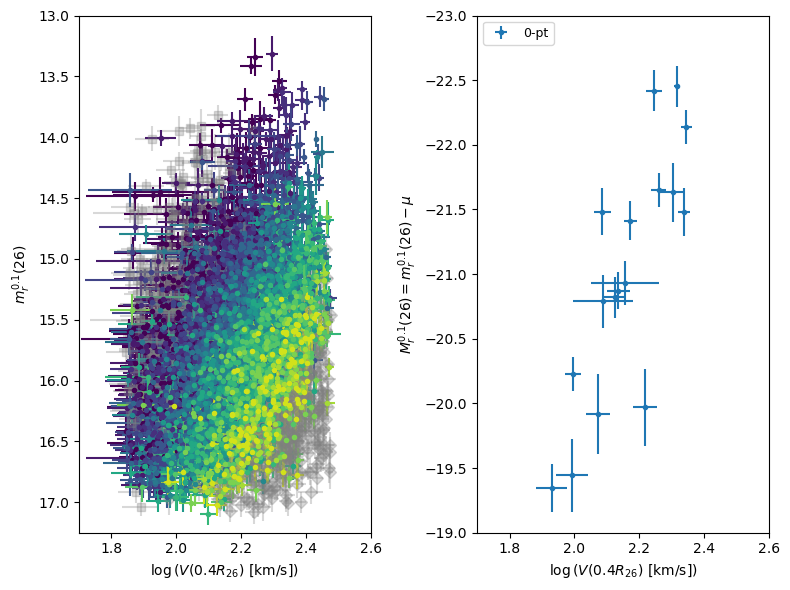

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.7, 2.6],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[17.25, 13],
       ylabel=r'$m_r^{0.1} (26)$')
# ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_ERR'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_ERR'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', color='tab:blue', label='0-pt')
ax.set(xlim=[1.7, 2.6],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-19, -23],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [51]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_ERR'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_ERR'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1826059224785923


## Multiline Fit using HyperFit

In [52]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

             message: Optimization terminated successfully.
             success: True
                 fun: -881717.6897753126
                   x: [-7.213e+00 -2.117e+01 ...  1.686e+01  4.659e-01]
                 nit: 197
                nfev: 53859
          population: [[-7.215e+00 -2.117e+01 ...  1.686e+01  4.664e-01]
                       [-7.216e+00 -2.120e+01 ...  1.685e+01  4.656e-01]
                       ...
                       [-7.210e+00 -2.119e+01 ...  1.687e+01  4.659e-01]
                       [-7.223e+00 -2.124e+01 ...  1.687e+01  4.665e-01]]
 population_energies: [-8.817e+05 -8.817e+05 ... -8.817e+05 -8.817e+05]
                 jac: [ 3.143e+00  0.000e+00 ...  2.095e-01  6.414e+00]
Ndim: 18 16


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.77it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.44711666 72.78806977 56.4207481  86.90775719 62.15811085 64.19698704
 57.74759656 66.71682973 57.74023966 65.00186076 68.33068874 67.63367003
 64.76665509 70.39967551 86.04172173 72.00103703 80.60576988 66.37472634] / 4345.387859699336


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.00it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.00339112  86.05187361  64.68908139  62.99693354  75.38329511
  63.57632062  74.29628472  78.30162989  74.267763    80.9329141
  85.83187205  82.76095181  89.65606098  83.95795755  91.1423463
  97.48268976  94.9213666  101.78849804] / 5089.424902203304


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.43it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.5652783  111.05257385  59.5755797   69.14673585  75.00284815
  70.67747456  76.82227518  78.19502074  82.89876087  90.21149327
  88.70748584  91.54889196  97.99566198 106.4760461  121.50828718
 116.97557449 120.887976   115.89664462] / 6075.414358833311


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.14it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [123.9151738  137.28779866  69.56192003  72.17501134  81.58517176
  71.60837224  85.42197066  87.74746457  91.69645593  96.19585087
 107.53552688 101.31336904  99.61511923 105.4992798  129.88380345
 119.8922713  122.82563565 133.57467658] / 6864.389933159623


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.04it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [137.99918785 141.56749445  61.21801572  86.50139412  78.46897552
  72.88450776  89.87026969  88.1831561   93.71602686  98.24501049
 108.36937318  97.37917024 109.04747325 122.65209133 130.97764424
 121.25909139 133.57251015 135.97924438] / 7078.374722526897


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.95it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [137.62778639 150.75401104  65.78811641  74.1617151   80.75742946
  81.48384347  89.85855425  91.51389292  85.45619655  96.30399629
 114.37155348 102.20022639 109.88110337 136.95680875 140.45290456
 128.55555535 136.8690342  160.23852902] / 8011.926450945701


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.28it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [139.03786057 151.50722056  66.50062581  75.55276163  85.69043576
  80.96788019  82.83212552  94.1014822   87.69718148 103.52060568
 119.85563848 118.97383713 104.05297574 137.53024916 150.54531312
 140.04941673 138.69216243 156.7946688 ] / 7839.733439901998


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.52it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [146.57385069 144.5949858   67.29515324  79.304248    87.75501612
  85.47335348  93.65153226 109.16279277  93.77125406  98.41874695
 118.00690978 124.73752675 106.93931648 141.93635809 151.17581673
 149.23461215 146.87449689 167.93456474] / 8396.72823685026


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.73it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [155.78359881 146.22893107  68.08603339  77.81280998  89.60535513
  89.70130837  92.75717164 110.92250278  94.60299165  93.76961776
 122.23821186 123.12997641 112.5634894  144.01111593 143.37369341
 151.30589793 144.66863284 172.66228262] / 8633.114130919592


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.75it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.4220214  141.78944048  71.11762312  75.5984763   96.84659525
  86.996358    98.73745178 115.17449739  97.20513171 100.96410201
 119.34109345 124.79552224 113.30830941 137.83986786 145.92847929
 164.36645089 155.62040253 173.19089781] / 8659.54489041449


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.14it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [158.08350062 150.18014557  68.57168234  74.76492957  96.52422168
  86.17672165 100.44386643 115.64287069 103.70717901 103.52035286
 120.5495249  133.01607699 116.15123809 137.8093435  151.29793898
 159.38294568 150.99451587 171.70892994] / 8585.446496788161


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.67it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.62902676 161.06169417  71.3657245   75.54469514  97.76760077
  86.14647406 100.53212623 120.15623901 106.48614538  99.88750037
 123.45666156 132.56723864 116.98931813 133.05311708 154.98062491
 165.62824422 159.0139911  166.3469444 ] / 8317.347219932815


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.60it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [160.50523399 167.46907992  68.71989811  77.53724918  98.85464457
  85.87227326 103.72440243 123.09680256 109.22792983 101.13876555
 128.778712   133.70077865 123.66664567 142.38346536 153.4464257
 177.19608727 149.26682157 166.60334174] / 8859.804363602523


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.58it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [165.92921801 163.34740257  71.38153071  76.69226314  97.92771579
  86.92713645 108.85623005 125.42528884 114.31235057 100.70546892
 128.78872817 129.34764512 126.82521781 141.59482399 154.29360846
 176.02633311 147.035593   169.32045888] / 8801.316655517889


In [53]:
temp_outfile = open('cov_ab_iron_jointTFR-cutsAlex_z0p1_zbins0p005_Anthony2_weightsVmax-1_dVsys_KAD-20250810.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

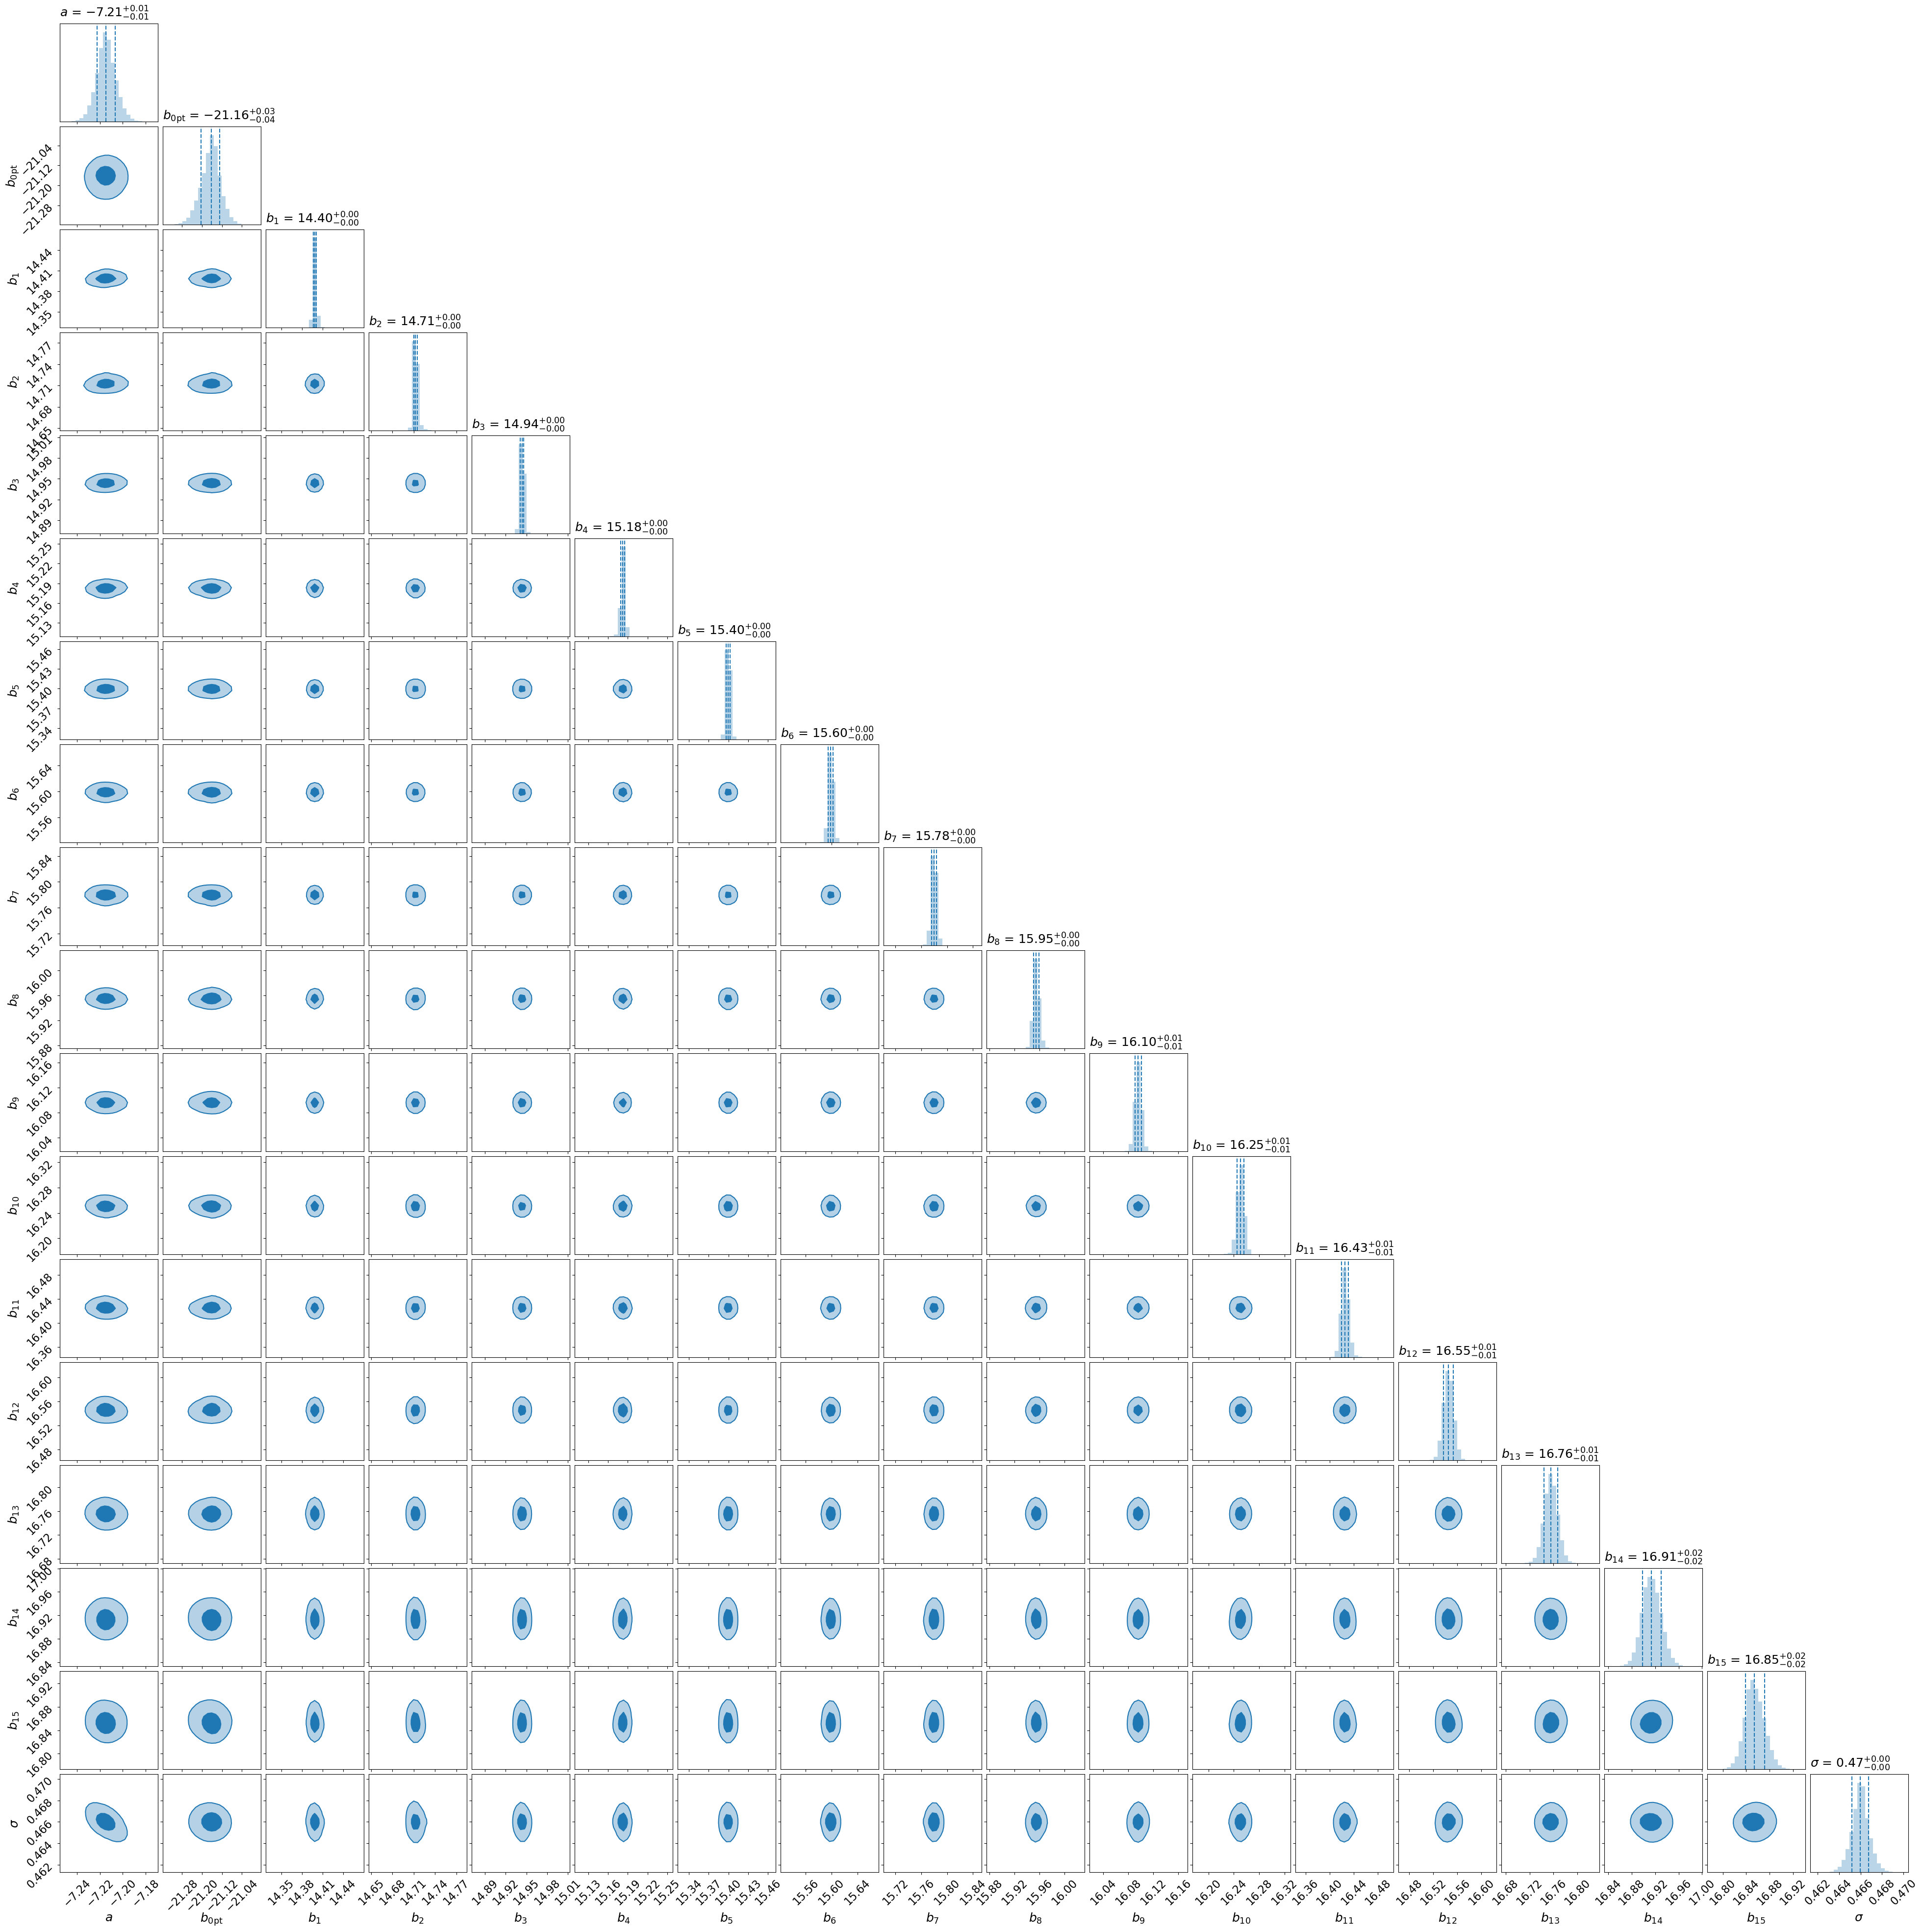

In [54]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

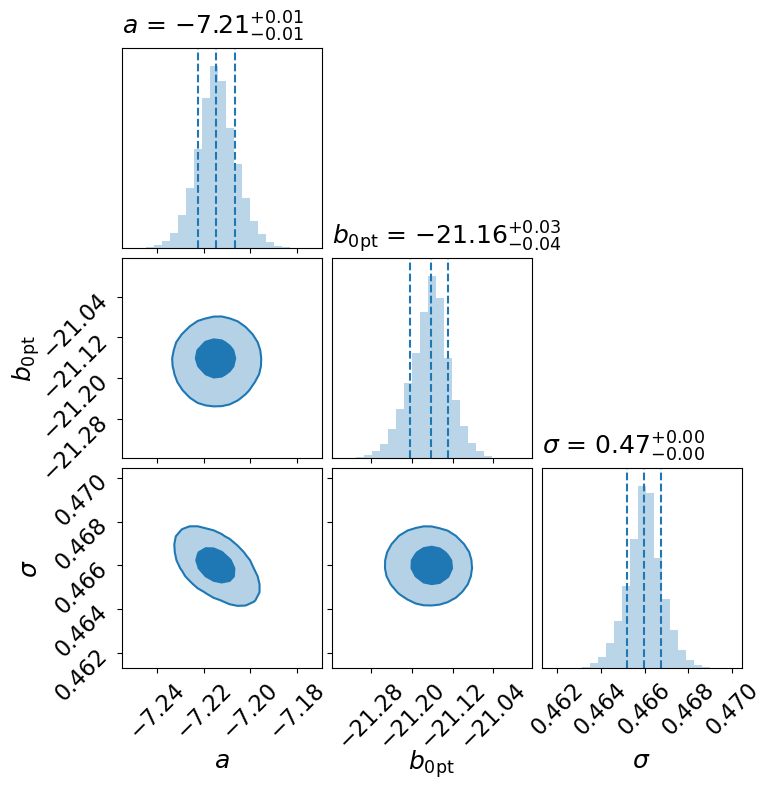

In [55]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

fig = corner(tfr_mcmc_samples[[0,1,-1],:].T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [56]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

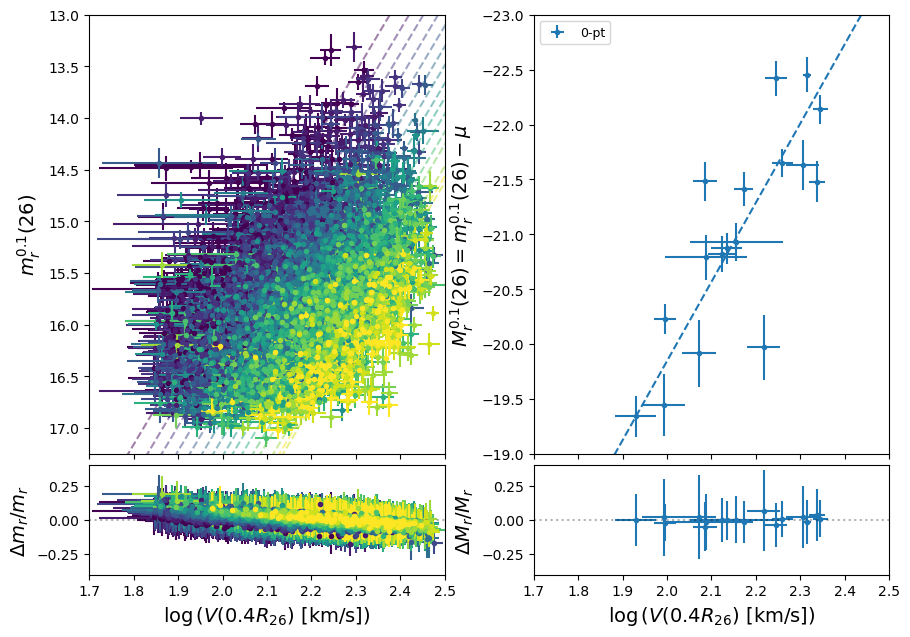

In [58]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot redshift bins
ax = axes[0,0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], 
                     xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.7, 2.5],
       ylim=[17.25, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.7, 2.5],
       ylim=[-19, -23]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.7, 2.5],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.7, 2.5],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [59]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.89 +/- 0.003


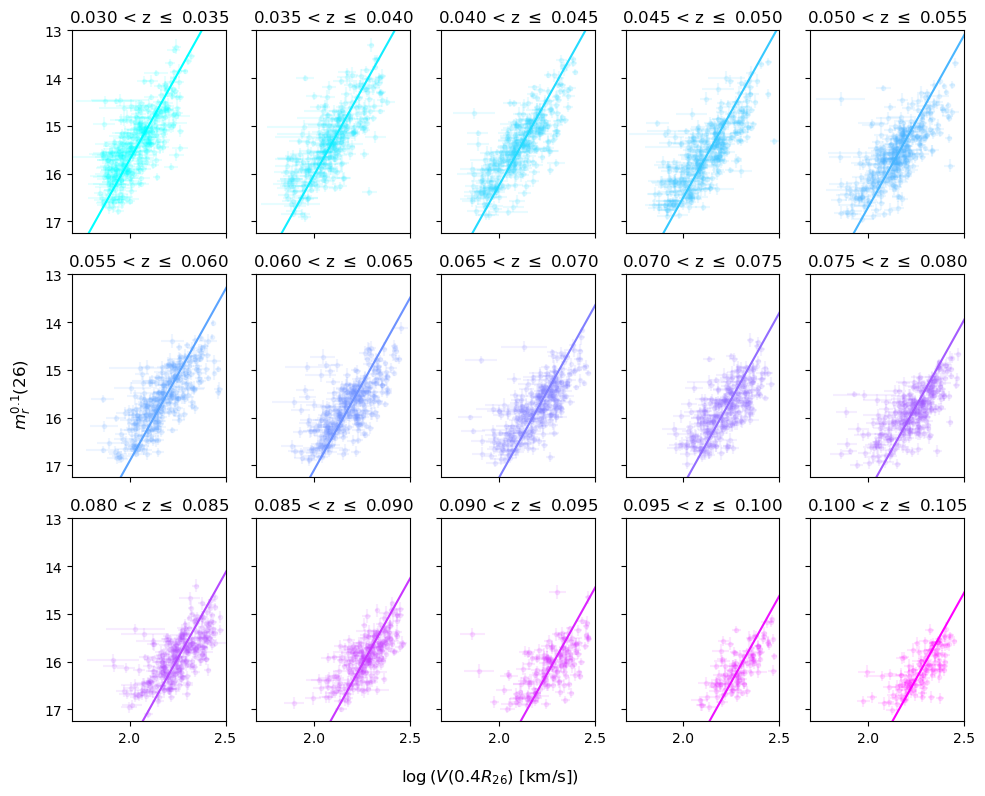

In [60]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.7, 2.5], ylim=[17.25, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')